# Self-energy

As it turns out, the matrix elements of the level-shift operator appearing in the resolvent can be computed through the following function

$$\Sigma(z,d) = \frac{g^2}{J} \frac{\beta_\mathrm{in}^{\lvert d\rvert}}{(\beta_\mathrm{in} - \beta_\mathrm{out})} \,, \quad \beta_\mathrm{in/out} = -\frac{z}{2J} \pm \mathrm{sign}\big(\mathrm{Re}(z)\big)\sqrt{\left(\frac{z}{2J}\right)^2 - 1} \,.$$

The single-emitter self-energy is simply $\Sigma_e(z) \equiv \Sigma(z, 0)$, whereas the "relative" self-energy for two emitters located at sites $x_1$ and $x_2$ is $\Sigma_{12}(z) \equiv \Sigma(z, x_1 - x_2)$, see [arXiv:2210.16137](https://arxiv.org/abs/2210.16137) (appendix A) and [arXiv:2305.11610](https://arxiv.org/abs/2305.11610) (appendix A.1). Its analytical continuation to the second Riemann sheet is obtained changing the sign of the square-root function ($\sqrt{\cdot}\to -\sqrt{\cdot}$), or, equivalently, switching $\beta_\mathrm{in} \leftrightarrow \beta_\mathrm{out}$.

# Single emitter

The single-emitter Green's function is 

$$G^+_e(t) := -i\theta(t) \langle e\rvert \hat U(t) \lvert e\rangle \,, \quad \lvert e\rangle \equiv \hat\sigma^+\lvert g\rangle \otimes \lvert\mathrm{vac}\rangle\,.$$

It's Fourier transform can be computed as

$$\tilde G^+_e(\omega) := \int_{-\infty}^\infty dt\, G^+_e(t) e^{i\omega t} = \lim_{\eta\to 0^+} \frac{1}{\omega + i\eta - \Delta - \Sigma_e(\omega + i\eta)} \,,$$

Thus, after coupling the emitter to the environment, the probability amplitude for it to remain excited (assuming the environment was in the vacuum state) can be calculated as a contour integral,

$$i G^+_e(t) \equiv c_e(t) = \frac{i}{2\pi} \int_{-\infty}^\infty d\omega\, \tilde G^+_e(\omega) e^{-i\omega t} = \sum_{z\in\mathrm{BS}} R(z) e^{-izt} + \sum_{z\in\mathrm{UP}} R(z) e^{-izt} + c_\mathrm{LBC}(t) + c_\mathrm{UBC}(t) \,.$$

This integral can be computed in different ways. Following [arXiv:1705.06677](https://arxiv.org/abs/1705.06677), we compute it as the sum of contributions stemming from the real poles of the single-emitter Green's function, complex poles of its analytic continuation in the region $\mathcal{R}_\mathrm{II} = \{z\in\mathbb{C} : \lvert \mathrm{Re}(z)\rvert < 2J \text{ and } \mathrm{Im}(z) < 0 \}$, and contributions stemming from the chosen branch cuts

\begin{align}
    c_\mathrm{UBC}(t) & := \frac{1}{2\pi} \int_0^\infty dy \, \left[\tilde G_e^\mathrm{I}(2J - iy) - \tilde G_e^\mathrm{II}(2J - iy)\right] e^{-i(2J - i y)t} \,,\\
    c_\mathrm{LBC}(t) & := \frac{1}{2\pi} \int_0^\infty dy \, \left[\tilde G_e^\mathrm{II}(-2J - iy) - \tilde G_e^\mathrm{I}(-2J - iy)\right] e^{-i(-2J - i y)t} \,.
\end{align}

# Non-Markovian driving term
The non-Markovian driving terms are elements of the vector $f_{NM}(t)$, given by 
$$\boldsymbol{f}_{NM}(t)=\int _0^t{\dot{\boldsymbol{W}}({t,\tau})\boldsymbol{f}({\tau})d\tau}-\dot{\boldsymbol{W}}\boldsymbol{W}^{-1}\tilde{\boldsymbol{f}}~~,  
$$
with
$$\tilde{\boldsymbol{f}}(t)=\int_0^t{\boldsymbol{W}({t,\tau})\boldsymbol{f}({\tau})d\tau}~~.$$

In [1]:
# single-emitter self-energy and its derivative (d = 0) in units of g^2/J

# first Riemann sheet
selfeI(z) = sign(real(z))/sqrt(Complex(z^2 - 4))
dselfeI(z) = -sign(real(z))*z/sqrt(Complex(z^2 - 4))^3

# second Riemann sheet
selfeII(z) = -selfeI(z)
dselfeII(z) = -dselfeI(z);

In [2]:
#using Pkg
#Pkg.add("Roots")
using Roots

# real poles and residues
function real_poles(Delta, g; eps=1e-12)    # Delta and g in units of J

    # find zero using a bisection algorithm,
    # the zero must be within the provided interval
    
    f(z) = z - Delta - g^2*real(selfeI(z))
    intervals = [(-10.0, -2.0 - eps), (2.0 + eps, 10.0)]
    poles = Vector{Float64}(undef, 2)
    residues = Vector{ComplexF64}(undef, 2)
    for (i, interval) in enumerate(intervals) 
        poles[i] = find_zero(f, interval)
        residues[i] = 1/(1 - g^2*dselfeI(poles[i]))
    end
    
    return poles..., residues...
end;

In [3]:
Delta1 = -0.1
g1 = 0.4;
zLBS, zUBS, rLBS, rUBS = real_poles(Delta1, g1)

(-2.0017687748290074, 2.0014487221995183, 0.0018558641269971578 + 0.0im, 0.0013763881864737955 + 0.0im)

In [4]:
#using Pkg
#Pkg.add("NLsolve")
using NLsolve

# complex pole and residue
function complex_pole(Delta, g)

    # A solution of the pole equation, f(z) = 0, is a solution to the non-linear 
    # system of equations F(x) = [0, 0]

    f(z) = z - Delta - g^2*selfeII(z)    
    F(x) = (y = f(Complex(x[1], x[2])); [real(y), imag(y)])    
    x0 = nlsolve(F, [Delta, -2.0]).zero    # complex pole in cartesian coordinates
                                           # a good initial guess is required
    zUP = Complex(x0[1], x0[2])
    rUP = 1/(1 - g^2*dselfeII(zUP))
    if abs(x0[1]) > 2 || x0[2] > 0    
        rUP = zero(rUP)    # the pole doesn't contribute if it's outside the integration contour
    end

    return zUP, rUP
end;

In [5]:
zUP, rUP = complex_pole(Delta1, g1)

(-0.09983997368525516 - 0.08003516778721101im, 0.9983838738432648 + 0.001983377283057982im)

In [6]:
#Pkg.add("QuadGK")
using QuadGK

# branch-cut contributions
function branch_cuts(Delta, g, t)

    GI(z) = 1/(z - Delta - g^2*selfeI(z))
    GII(z) = 1/(z - Delta - g^2*selfeII(z))

    # lower branch cut
    fLBC(y) = exp(-y*t)*(GII(-2 - im*y) - GI(-2 - im*y))
    LBC = exp(2im*t)/(2pi) * quadgk(fLBC, 0, Inf)[1]

    # upper branch cut
    fUBC(y) = exp(-y*t)*(GI(2 - im*y) - GII(2 - im*y))
    UBC = exp(-2im*t)/(2pi) * quadgk(fUBC, 0, Inf)[1]

    return LBC, UBC
end;

In [7]:
LBC, UBC = branch_cuts(Delta1, g1, 0)

(-0.0009279320698824281 - 0.013732285567265391im, -0.0006881940996207264 + 0.011748908284207375im)

A good test to see if all parts are computed correctly is to check that $c_e(0) = 1$.

In [8]:
rLBS + rUBS + rUP + LBC + UBC

0.9999999999872325 - 3.469446951953614e-17im

In [9]:
function NE_greens_1_emit(Delta, g, times)
    zLBS, zUBS, rLBS, rUBS = real_poles(Delta, g)
    zUP, rUP = complex_pole(Delta, g)
    W1 = Vector{ComplexF64}(undef, length(times))
    for (i, t) in enumerate(times)
        W1[i] = (rLBS*exp(-im*zLBS*t) + rUBS*exp(-im*zUBS*t) + rUP*exp(-im*zUP*t) + sum(branch_cuts(Delta, g, t)))
    end
    return W1
end;

In [10]:
#using Pkg
#Pkg.add("Dierckx")
using Dierckx
#tvec = range(tmin,tmax,length = 2^8)
function num_deriv(y,xs)
    yint = Spline1D(xs,y,bc="nearest")
    dy(x) = derivative(yint,x)
    return dy
end;

In [11]:
using Dierckx
function f_nm(W1,times,f)
    W1re = real(W1);
    W1im = imag(W1);
    W1re_interp = Spline1D(times,W1re,bc="nearest")
    W1im_interp = Spline1D(times,W1im,bc="nearest")
    dW1re(s) = derivative(W1re_interp,s)
    dW1im(s) = derivative(W1im_interp,s)
 
    freal(s) = real(f1(s));
    fimag(s) = imag(f1(s));
    
    Inttot= Vector{ComplexF64}(undef, length(times))
    #Int_1vec= Vector{ComplexF64}(undef, length(times))
    #Int_2vec= Vector{ComplexF64}(undef, length(times))
    for (i, t) in enumerate(times)
        Reintegr1(s) = dW1re(t-s)*real(f(s))-dW1im(t-s)*imag(f(s));
        Imintegr1(s) = dW1im(t-s)*real(f(s))+dW1re(t-s)*imag(f(s));
        Reintegr2(s) = W1re_interp(t-s)*real(f(s))-W1im_interp(t-s)*imag(f(s));
        Imintegr2(s) = W1im_interp(t-s)*real(f(s))+W1re_interp(t-s)*imag(f(s));
        Int_1 = quadgk(Reintegr1,0,t)[1]+im*quadgk(Imintegr1,0,t)[1];
        Int_2 = quadgk(Reintegr2,0,t)[1]+im*quadgk(Imintegr2,0,t)[1];
        W1_t = W1re_interp(t)+im*W1im_interp(t);
        dW1_t = dW1re(t)+im*dW1im(t)
        Inttot[i] = Int_1 - (dW1_t/W1_t)*Int_2;  
        #Int_1vec[i] = Int_1;
        #Int_2vec[i] = (dW1_t/W1_t)*Int_2;
        
       # fnm[i] = int1 - (dW1./W1)*int2
    end
    return Inttot
end;   

In [12]:
function NE_greens_1_emit_approx(Delta, g, times)
    zLBS, zUBS, rLBS, rUBS = real_poles(Delta, g)
    zUP, rUP = complex_pole(Delta, g)
    W1 = Vector{ComplexF64}(undef, length(times))
    for (i, t) in enumerate(times)
        W1[i] = (rUP*exp(-im*zUP*t) )
    end
    return W1
end;
#rLBS*exp(-im*zLBS*t) + rUBS*exp(-im*zUBS*t)++ sum(branch_cuts(Delta, g, t))

# Single emitter plots

In [13]:
g = 0.4;
Deltas = range(-4.0, 4.0, length=100)
zLBS = Vector{Float64}(undef, length(Deltas))
zUBS = similar(zLBS)
rLBS = Vector{ComplexF64}(undef, length(Deltas))
rUBS = similar(rLBS)
zUP = similar(rLBS)
rUP = similar(rLBS)
LBC = similar(rLBS)
UBC = similar(rLBS)
for (i, Delta) in enumerate(Deltas)
    zLBS[i], zUBS[i], rLBS[i], rUBS[i] = real_poles(Delta, g)
    zUP[i], rUP[i] = complex_pole(Delta, g)
    LBC[i], UBC[i] = branch_cuts(Delta, g,0)
end;

In [14]:
#using Pkg
#Pkg.add("LaTeXStrings")

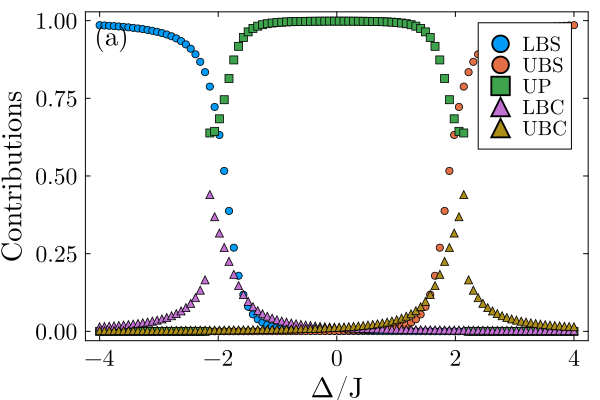

In [21]:
using Plots
using LaTeXStrings
plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=2, framestyle=:box, label=nothing, grid=false)

 
scatter(Deltas, abs.(rLBS), label="LBS")
scatter!(Deltas, abs.(rUBS), label="UBS")
scatter!(Deltas, abs.(rUP), marker=:square, label="UP")
scatter!(Deltas, abs.(LBC), marker=:utriangle, label="LBC")
scatter!(Deltas, abs.(UBC), marker=:utriangle, label="UBC")
scatter!(xlabel="Δ/J", ylabel="Contributions",xguidefontsize=18,yguidefontsize=18,legendfontsize=13,ytickfontsize=15,xtickfontsize=15)
ftr = text("(a)", :black, :right,font(17,"Computer Modern"))
annotate!(-3.8, 0.95, ftr)

In [22]:
savefig("contribution.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/contribution.png"

In [16]:
# Comparison of the decay
Gamma = -2*imag(zUP)
# Markovian prediction
heavyside(x) = x > 0 ? 1.0 : x == 0.0 ? 0.5 : 0.0;
J = 1
g = 0.4;
Deltas_band = range(-1.9, 1.9, length=100)
Gamma_markov= Vector{ComplexF64}(undef, length(Deltas))
for (i,Delta) in enumerate(Deltas_band)
    DOS_markov = (1 / π) * (1 ./ sqrt.(4 * J^2 - Delta^2)) .* heavyside.(2 * J - abs.(Delta))
    Gamma_markov[i] = 2* π * g^2 * DOS_markov
end

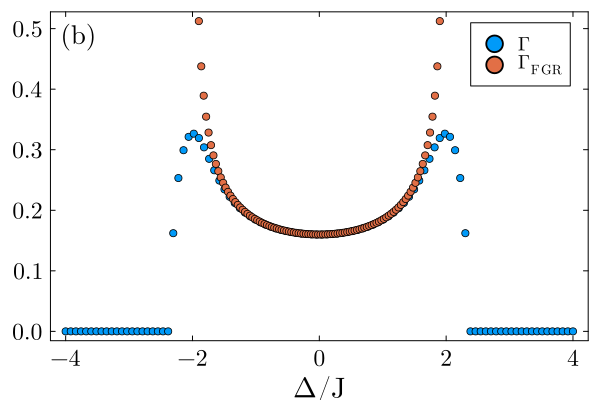

In [19]:
plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=2, framestyle=:box, label=nothing, grid=false)
scatter(Deltas,Gamma,label = latexstring("\\Gamma"))
scatter!(Deltas_band,real(Gamma_markov),label = latexstring("\\Gamma_{\\mathrm{FGR}}"))
scatter!(xlabel="Δ/J",xguidefontsize=18,yguidefontsize=18,legendfontsize=13,ytickfontsize=15,xtickfontsize=15)
ftr = text("(b)", :black, :right,font(17,"Computer Modern"))
annotate!(-3.8, 0.49, ftr)

In [20]:
savefig("decay_rates.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/decay_rates.png"

In [24]:
sig = 0.5;
t0 = 4;
A = 1;
Ag = 2;
delta_L = 0.5;
Delta2 = -1.0;
f_gauss(s) = (Ag/(sqrt(2pi*sig^2)))*exp(-(s-t0)^2/(2*sig^2))
#f_mono(s) = A*cos(delta_L*s);
f_mono(s) = A*exp(im*delta_L*s);

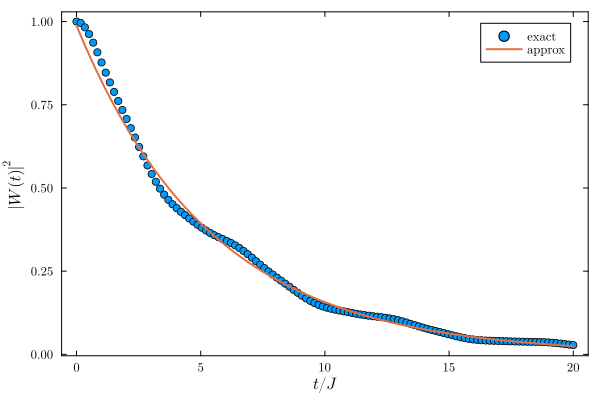

In [25]:
#Pkg.add("Plots")
using Plots
using LaTeXStrings
Delta2 = -1.0;
tend = 20
times = range(0, tend, length=120)
W1vec = NE_greens_1_emit(Delta2, 0.4, times);
W1vec_approx = NE_greens_1_emit_approx(Delta2, 0.4, times);
scatter(times, abs2.(W1vec), label = "exact")
plot!(times, abs2.(W1vec_approx), label = "approx")
ylab = latexstring("|W(t)|^2")
plot!(xlabel=latexstring("t/J"), ylabel=ylab)
#println(abs(W1vec[end]))

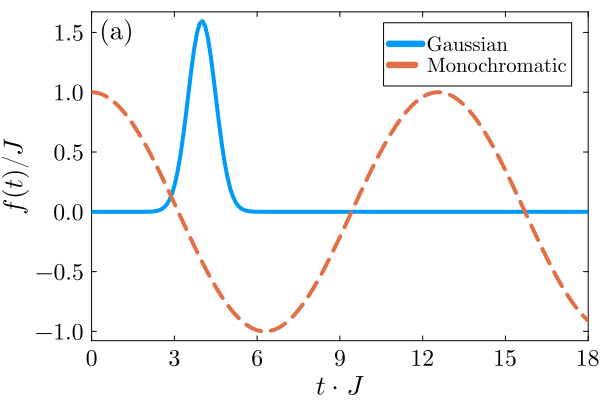

In [29]:
using Plots
using LaTeXStrings
times = range(0, tend, length=200)

plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=2, framestyle=:box, label=nothing, grid=false)
#scatter(times,real(f_const.(times)),label = "const")
plot(times,real(f_gauss.(times)),label = "Gaussian",linewidth = 4)
plot!(times,real(f_mono.(times)),label = "Monochromatic",linewidth = 4,linestyle=:dash )
scatter!(xlabel = latexstring("t\\cdot J"),ylabel = latexstring("f(t)/J"),legendfontsize=13,ytickfontsize=15,xlims =[0,18],xtickfontsize=15, xguidefontsize=18,yguidefontsize=18)
ftr = text("(a)", :black, :right,font(17,"Computer Modern"))
annotate!(0.9, 1.52, ftr)

In [30]:
savefig("driving_plot.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/driving_plot.png"

# Comparison for different coupling strength and detuning

In [31]:
tend = 20;
times = range(0, tend, length=100)
g_vec = [0.4 0.1]
Delta_vec = [-3.0 -2.0 -1.0 -0.1]
# g =0.4, Delta = -3
#W1_mat = Vector{ComplexF64}(undef, length(times))
W1_mat = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
f_nm_mat_gauss = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
f_nm_mat_mono = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
#W1_mat = NE_greens_1_emit(g_vec[1], Delta_vec[1], times)

for (i,g) in enumerate(g_vec)
    for(ii,Delta) in enumerate(Delta_vec)
        W1_mat[i,ii,:] = NE_greens_1_emit(Delta,g, times)
        f_nm_mat_gauss[i,ii,:] = f_nm(W1_mat[i,ii,:],times,f_gauss)
        f_nm_mat_mono[i,ii,:] = f_nm(W1_mat[i,ii,:],times,f_mono)
    end
end

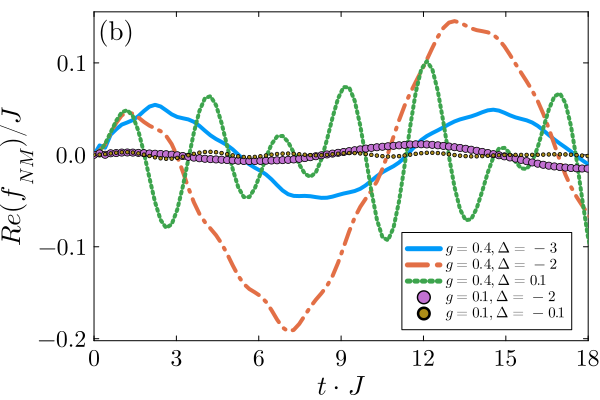

In [34]:


plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=2, framestyle=:box, label=nothing, grid=false)

plot(times,real(f_nm_mat_mono[1,1,:]),label = latexstring("{g=0.4, \\Delta = -3}"),linewidth = 4)
#=
for (i,g) in enumerate(g_vec)
    for (ii,Delta) in enumerate(Delta_vec)
        scatter!(times,real(f_nm_mat_mono[i,ii,:]),label = "g=$g, Delta = $Delta")
    end
end
=#
plot!(times,real(f_nm_mat_mono[1,2,:]),label = latexstring("g=0.4, \\Delta = -2"),linewidth = 4,linestyle = :dashdot)
#plot!(times,real(f_nm_mat_mono[1,3,:]),label = "g=0.4, Delta = -1",linewidth = 3,linestyle=:dash)
plot!(times,real(f_nm_mat_mono[1,4,:]),label = latexstring("g=0.4, \\Delta = 0.1"),linewidth = 4,linestyle=:dot)
scatter!(times,real(f_nm_mat_mono[2,2,:]),label = latexstring("g=0.1, \\Delta = -2"),linewidth = 4)
scatter!(times,real(f_nm_mat_mono[2,4,:]),label = latexstring("g=0.1, \\Delta = -0.1"),markersize =2)
scatter!(xlabel=latexstring("t \\cdot J"), ylabel=latexstring("Re(f_{NM})/J"),legendfontsize=10,legend=:bottomright,xlims =[0,18],ytickfontsize=15,xtickfontsize=15, xguidefontsize=18,yguidefontsize=18)
ftr = text("(b)", :black, :right,font(17,"Computer Modern"))
annotate!(0.8, 0.135, ftr)

In [35]:
savefig("fnm_mono.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/fnm_mono.png"

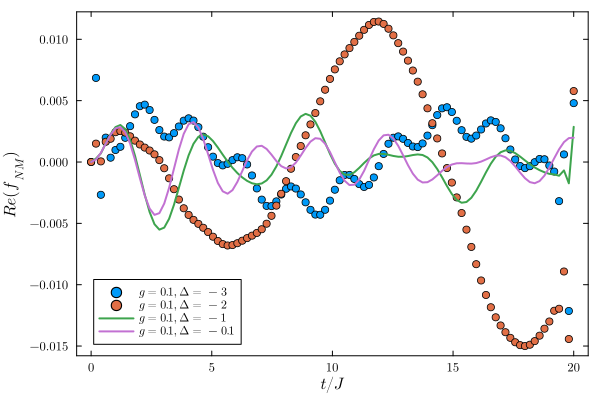

In [41]:
scatter(times,real(f_nm_mat_mono[2,1,:]),label = latexstring("g=0.1, \\Delta = -3"))
scatter!(times,real(f_nm_mat_mono[2,2,:]),label = latexstring("g=0.1, \\Delta = -2"))
plot!(times,real(f_nm_mat_mono[2,3,:]),label = latexstring("g=0.1, \\Delta = -1"))
plot!(times,real(f_nm_mat_mono[2,4,:]),label = latexstring("g=0.1, \\Delta = -0.1"))
scatter!(xlabel=latexstring("t/J"), ylabel=latexstring("Re(f_{NM})"))

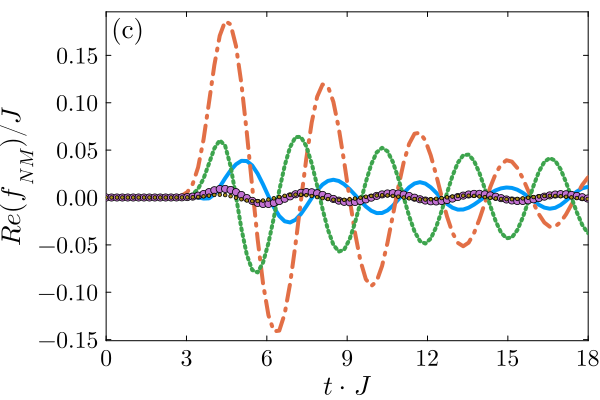

In [36]:

plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=2, framestyle=:box, label=nothing, grid=false)
g = 0.4;
plot(times,real(f_nm_mat_gauss[1,1,:]),linewidth = 4)
plot!(times,real(f_nm_mat_gauss[1,2,:]),linewidth = 4,linestyle = :dashdot)
#plot!(times,real(f_nm_mat_gauss[1,3,:]),label = "g=$g, Delta = -1")
plot!(times,real(f_nm_mat_gauss[1,4,:]),linewidth = 4,linestyle=:dot)
scatter!(times,real(f_nm_mat_gauss[2,2,:]))
scatter!(times,real(f_nm_mat_gauss[2,4,:]),markersize =2)
scatter!(xlabel=latexstring("t\\cdot J"), ylabel=latexstring("Re(f_{NM})/J"),xlims = [0,18],ytickfontsize=15,xtickfontsize=15, legend = false, xguidefontsize=18,yguidefontsize=18)
ftr = text("(c)", :black, :right,font(17,"Computer Modern"))
annotate!(0.8, 0.178, ftr)

In [37]:
savefig("fnm_gauss.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/fnm_gauss.png"

# Comparison of different coupling strengths

In [46]:
using Ranges
tend = 20;
times = range(0, tend, length=100)
g_vec = range(start = 0.05,stop = 0.4, step = 0.05)
Delta = -3 
# g =0.4, Delta = -3
#W1_mat = Vector{ComplexF64}(undef, length(times))
W1_mat = Array{ComplexF64}(undef,length(g_vec),length(times))
f_nm_mat_gauss = Array{ComplexF64}(undef,length(g_vec),length(times))
f_nm_mat_mono = Array{ComplexF64}(undef,length(g_vec),length(times))
#W1_mat = NE_greens_1_emit(g_vec[1], Delta_vec[1], times)
max_vec = Vector{ComplexF64}(undef,length(g_vec))
for (i,g) in enumerate(g_vec)
    W1_mat[i,:] = NE_greens_1_emit(Delta,g, times)
    f_nm_mat_gauss[i,:] = f_nm(W1_mat[i,:],times,f_gauss)
    f_nm_mat_mono[i,:] = f_nm(W1_mat[i,:],times,f_mono)
    max_vec[i] = maximum(abs.(f_nm_mat_gauss[i,:]))
end

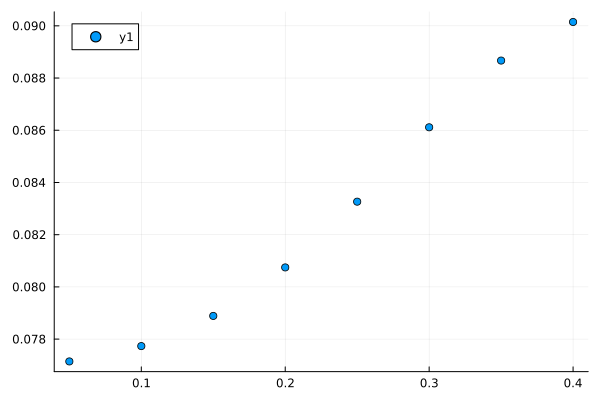

In [47]:
scatter(g_vec,real(max_vec))
#println(real(max_vec))

In [48]:
real(max_vec[6])/real(max_vec[3])

1.0915870178550653

## Two modes

For two emitters we can write down four different Green's functions,

$$G^+_{mn}(t) := -i\theta(t)\langle m\rvert \hat U(t) \lvert n\rangle\,, \quad \lvert n\rangle \equiv \hat\sigma^+_n \lvert g g\rangle \lvert \mathrm{vac}\rangle\,, \ n\in\{1,2\}\,.$$

These can be collected in a matrix, whose Fourier transform is

$$\tilde G^+(\omega) = \left[(\omega + i0^+ - \Delta)I - \Sigma(\omega + i0^+)\right]^{-1}\,.$$

Here, $I$ denotes the $2\times 2$ identity matrix, and

$$\Sigma(z) = \begin{bmatrix}\Sigma_e(z) & \Sigma_{12}(z) \\ \Sigma_{21}(z) & \Sigma_e(z)\end{bmatrix}$$

is the so-called self-energy matrix. Due to the symmetries of the model we have that $\Sigma_{12}(z) = \Sigma_{21}(z)$, which, in turn, implies that the self-energy matrix $\Sigma(z)$ has eigenvalues $\Sigma_\pm = \Sigma_e(z) \pm \Sigma_{12}(z)$ and eigenvectors $v_\pm = (1, \pm 1)$. Denoting by $P_\pm$ the projectors onto the corresponding eigensubspaces,

$$\tilde G^+(\omega) = \tilde G^+_+(\omega) P_+ + \tilde G^+_-(\omega) P_- \,, \quad \tilde G^+_\pm(\omega) = \frac{1}{\omega + i0^+ - \Delta - \Sigma_\pm(\omega + i0^+)} \,.$$

Denoting by $c_n(t)$ the probability amplitude that the $n$th emitter is in the excited state, we have for an initial state in which the first emitter is excited that

$$c_1(t) = \frac{c_+(t) + c_-(t)}{2}\,, \ c_2(t) = \frac{c_+(t) - c_-(t)}{2}\,,$$

where $c_\pm(t) \equiv i G^+_\pm(t)$.


The non-Markovian drive term in the master equation,  $f_{NM}$, obtains the form 
$\boldsymbol{f}_{NM}(\tau) \equiv \boldsymbol{X} \boldsymbol{\bar{f}}_{NM}(\tau)$  
with 
$$\boldsymbol{\bar{f}}_{NM} = \{\bar{f}_{NM+},\bar{f}_{NM-}\}^T~~,$$ and
$$\bar{f}_{NM\pm}(t)=\int_0^t{W_\pm(t-\tau)\bar{{f}}_\pm({\tau})}\\-\dot{W}_\pm{W_{\pm}^{-1}}\int_0^t{W_{\pm}({t-\tau})\bar{f}_\pm(\tau)d\tau}~~.$$

In [38]:
# self-energy function and its derivative in units of g^2/J

function selfeI(z, d) 
    s = sign(real(z))
    t = sqrt(Complex(z^2 - 4))
    return s/t * ((-z + s*t)/2)^d
end
function dselfeI(z, d)
    s = sign(real(z))
    t = sqrt(Complex(z^2 - 4))
    return s/(2t)*((-z + s*t)/2)^(d - 1)*(s*z*(d - 1)/t + (z/t)^2 - d)
end


function selfeII(z, d) 
    s = -sign(real(z))
    t = sqrt(Complex(z^2 - 4))
    return s/t * ((-z + s*t)/2)^d
end
function dselfeII(z, d)
    s = -sign(real(z))
    t = sqrt(Complex(z^2 - 4))
    return s/(2t)*((-z + s*t)/2)^(d - 1)*(s*z*(d - 1)/t + (z/t)^2 - d)
end

# self-energy for the even/odd superposition 

selfeI(z, d, parity) = selfeI(z, 0) + parity*selfeI(z, d)
dselfeI(z, d, parity) = dselfeI(z, 0) + parity*dselfeI(z, d)

selfeII(z, d, parity) = selfeII(z, 0) + parity*selfeII(z, d)
dselfeII(z, d, parity) = dselfeII(z, 0) + parity*dselfeII(z, d);

In contrast with the single-emitter case, for two emitters there are not always two bound states.

In [39]:
using Roots

# real poles and residues
function real_poles(Delta, g, d, parity; eps=1e-12)    # Delta and g in units of J

    # find zero using a bisection algorithm,
    # the zero must be within the provided interval

    f(z) = z - Delta - g^2*real(selfeI(z, d, parity))
    intervals = [(-10.0, -2.0 - eps), (2.0 + eps, 10.0)]
    poles = Vector{Float64}(undef, 2)
    residues = Vector{ComplexF64}(undef, 2)
    for (i, interval) in enumerate(intervals) 
        if f(interval[1])*f(interval[2]) < 0
            poles[i] = find_zero(f, interval)
            residues[i] = 1/(1 - g^2*dselfeI(poles[i], d, parity))
        else
            poles[i] = NaN
            residues[i] = NaN
        end
    end
    
    return poles..., residues...
end;

In [40]:
Deltas = range(-4.0, 4.0, length=100)
zLBS = Vector{Float64}(undef, length(Deltas))
zUBS = similar(zLBS)
rLBS = Vector{ComplexF64}(undef, length(Deltas))
rUBS = similar(rLBS)
for (i, Delta) in enumerate(Deltas)
    zLBS[i], zUBS[i], rLBS[i], rUBS[i] = real_poles(Delta, 0.4, 2, 1)
end;

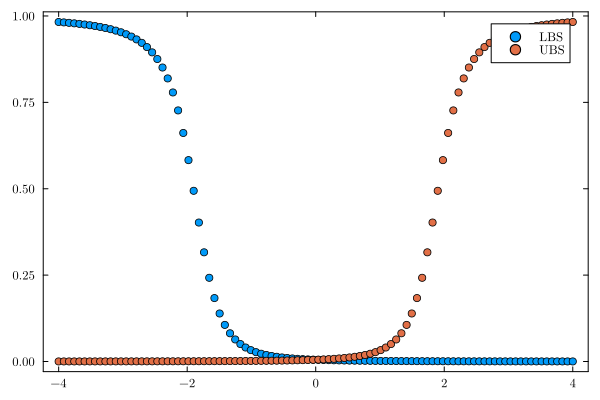

In [41]:
using Plots

scatter(Deltas, abs.(rLBS), label="LBS")
scatter!(Deltas, abs.(rUBS), label="UBS")

In [42]:
using NLsolve

# complex pole and residue
function complex_pole(Delta, g, d, parity)

    # A solution of the pole equation, f(z) = 0, is a solution to the non-linear 
    # system of equations F(x) = [0, 0]

    f(z) = z - Delta - g^2*selfeII(z, d, parity)    
    F(x) = (y = f(Complex(x[1], x[2])); [real(y), imag(y)])    
    x0 = nlsolve(F, [Delta, -2.0]).zero    # complex pole in cartesian coordinates
                                           # a good initial guess is required
    zUP = Complex(x0[1], x0[2])
    rUP = 1/(1 - g^2*dselfeII(zUP, d, parity))
    if abs(x0[1]) > 2 || x0[2] > 0    
        rUP = NaN    # the pole doesn't contribute if it's outside the integration contour
    end

    return zUP, rUP
end;

In [43]:
zUP = similar(rLBS)
rUP = similar(rLBS)
for (i, Delta) in enumerate(Deltas)
    zUP[i], rUP[i] = complex_pole(Delta, 0.4, 2, 1)
end;

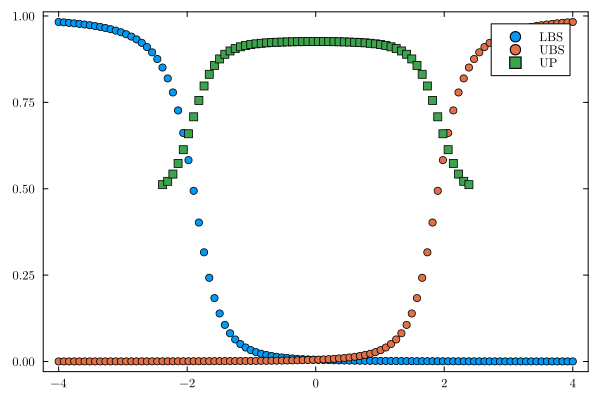

In [44]:
scatter!(Deltas, abs.(rUP), marker=:square, label="UP")

In [45]:
using QuadGK

# branch-cut contributions
function branch_cuts(Delta, g, d, parity, t)

    GI(z) = 1/(z - Delta - g^2*selfeI(z, d, parity))
    GII(z) = 1/(z - Delta - g^2*selfeII(z, d, parity))

    # lower branch cut
    fLBC(y) = exp(-y*t)*(GII(-2 - im*y) - GI(-2 - im*y))
    LBC = exp(2im*t)/(2pi) * quadgk(fLBC, 0, Inf)[1]

    # upper branch cut
    fUBC(y) = exp(-y*t)*(GI(2 - im*y) - GII(2 - im*y))
    UBC = exp(-2im*t)/(2pi) * quadgk(fUBC, 0, Inf)[1]

    return LBC, UBC
end;

In [46]:
LBC = similar(rLBS)
UBC = similar(rLBS)
for (i, Delta) in enumerate(Deltas)
    LBC[i], UBC[i] = branch_cuts(Delta, 0.4, 2, 1, 0)
end;

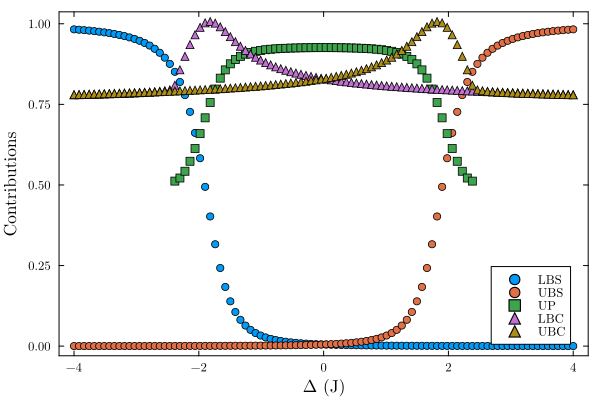

In [47]:
scatter!(Deltas, abs.(LBC), marker=:utriangle, label="LBC")
scatter!(Deltas, abs.(UBC), marker=:utriangle, label="UBC")
scatter!(xlabel="Δ (J)", ylabel="Contributions")

In [48]:
nan_to_zero(val) = isnan(val) ? zero(val) : val;

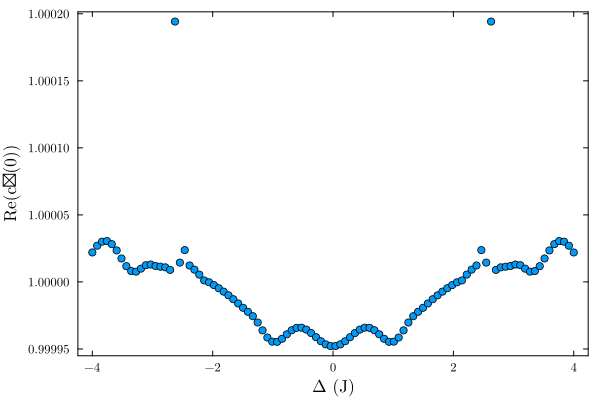

GKS: glyph missing from current font: 8330
GKS: glyph missing from current font: 8330
GKS: glyph missing from current font: 8330
GKS: glyph missing from current font: 8330
GKS: glyph missing from current font: 8330


In [49]:
rLBS = nan_to_zero.(rLBS)
rUBS = nan_to_zero.(rUBS)
rUP = nan_to_zero.(rUP)
scatter(Deltas, real.(rLBS + rUBS + rUP + LBC + UBC))
scatter!(xlabel="Δ (J)", ylabel="Re(c₊(0))", legend=false)

In [50]:
function excited_amplitudes(Delta, g, d, times)
    zLBSp, zUBSp, rLBSp, rUBSp = nan_to_zero.(real_poles(Delta, g, d, 1))
    zUPp, rUPp = nan_to_zero.(complex_pole(Delta, g, d, 1))
    zLBSm, zUBSm, rLBSm, rUBSm = nan_to_zero.(real_poles(Delta, g, d, -1))
    zUPm, rUPm = nan_to_zero.(complex_pole(Delta, g, d, -1))
    cp = Vector{ComplexF64}(undef, length(times))
    cm = similar(cp)
    for (i, t) in enumerate(times)
        cp[i] = (rLBSp*exp(-im*zLBSp*t) + rUBSp*exp(-im*zUBSp*t) 
                 + rUPp*exp(-im*zUPp*t) + sum(branch_cuts(Delta, g, d, 1, t)))
        cm[i] = (rLBSm*exp(-im*zLBSm*t) + rUBSm*exp(-im*zUBSm*t) 
                 + rUPm*exp(-im*zUPm*t) + sum(branch_cuts(Delta, g, d, -1, t)))
    end
    return (cp + cm)/2, (cp - cm)/2
end;

In [51]:
function NE_greens_2_emit(Delta, g, d, times)
    zLBSp, zUBSp, rLBSp, rUBSp = nan_to_zero.(real_poles(Delta, g, d, 1))
    zUPp, rUPp = nan_to_zero.(complex_pole(Delta, g, d, 1))
    zLBSm, zUBSm, rLBSm, rUBSm = nan_to_zero.(real_poles(Delta, g, d, -1))
    zUPm, rUPm = nan_to_zero.(complex_pole(Delta, g, d, -1))
    cp = Vector{ComplexF64}(undef, length(times))
    cm = similar(cp)
    for (i, t) in enumerate(times)
        cp[i] = (rLBSp*exp(-im*zLBSp*t) + rUBSp*exp(-im*zUBSp*t) 
                 + rUPp*exp(-im*zUPp*t) + sum(branch_cuts(Delta, g, d, 1, t)))
        cm[i] = (rLBSm*exp(-im*zLBSm*t) + rUBSm*exp(-im*zUBSm*t) 
                 + rUPm*exp(-im*zUPm*t) + sum(branch_cuts(Delta, g, d, -1, t)))
    end
    return cp, cm
end;

In [52]:
times = range(0, 100, length=100)
c1, c2 = excited_amplitudes(-2.0, 0.4, 2, times);

In [53]:
times = range(0, 100, length=100)
Wp, Wm = NE_greens_2_emit(-2.0, 0.4, 2, times);

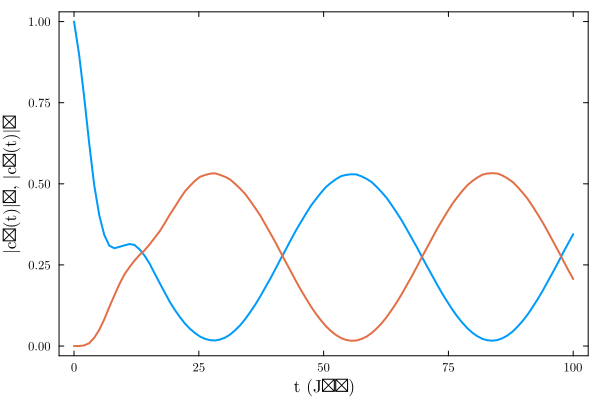

GKS: glyph missing from current font: 8315
GKS: glyph missing from current font: 185
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 8315
GKS: glyph missing from current font: 185
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 8315
GKS: glyph missing from current font: 185
GKS: glyph missing from current font: 8315
GKS: glyph missing from current font: 185
GKS: glyph missing from current font: 8315
GKS: glyph missing from current font: 185
GKS: glyph missing from current font: 8321
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 8322
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 8321
GKS: glyph missing fro

In [54]:
plot(times, abs2.(c1), legend=false)
plot!(times, abs2.(c2), legend=false)
plot!(xlabel="t (J⁻¹)", ylabel="|c₁(t)|², |c₂(t)|²")

In [56]:
function f_nm_2em(Wp,Wm,times,f1,f2)
    fp(s) = (1/sqrt(2))*(f1(s) + f2(s)) 
    fm(s) = (1/sqrt(2))*(f1(s)- f2(s))
    f_nm_2em_p = f_nm(Wp,times,fp);
    f_nm_2em_m = f_nm(Wm,times,fm);
    f_mat_2em = [transpose(f_nm_2em_p);transpose(f_nm_2em_m)];
    X = (1/sqrt(2))*[1 1;1 -1];
    f_nm_1= Vector{ComplexF64}(undef, length(times))
    f_nm_2= Vector{ComplexF64}(undef, length(times))
    for (i,time) in enumerate(times)
        temp1 = X*f_mat_2em[:,i]
        temp2  = X*f_mat_2em[:,i]
        f_nm_1[i] = temp1[1]
        f_nm_2[i] = temp2[2]
    end
    return f_nm_1, f_nm_2
end;

In [57]:
tend = 20;
times = range(0, tend, length=120)
g_vec = [0.4 0.1]
Delta_vec = [-3.0 -2.0 -1.0 -0.1]
sig = 0.5;
t0 = 4;
A = 1;
Ag = 2;
d=2;
delta_L = 0.5;
#f_const(s) = 1;
f_gauss(s) = (Ag/(sqrt(2pi*sig^2)))*exp(-(s-t0)^2/(2*sig^2))
f_mono(s) = A*exp(im*delta_L*s)
f2(s) = 0;
#Wp1, Wm1 = NE_greens_2_emit(-2.0, 0.4, 2, times);
#f_nm_gauss_1new, f_nm_gauss_2 = f_nm_2em(Wp1,Wm1,times,f_gauss,f2);
#f_nm_mono_1, f_nm_mono_2 = f_nm_2em(Wp1,Wm1,times,f_mono,f2);

Wp_mat = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
Wm_mat = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
f_nm_mat_gauss1 = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
f_nm_mat_mono1 = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
f_nm_mat_gauss2 = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))
f_nm_mat_mono2 = Array{ComplexF64}(undef,length(g_vec),length(Delta_vec),length(times))

for (i,g) in enumerate(g_vec)
    for(ii,Delta) in enumerate(Delta_vec)
        Wp_mat[i,ii,:],Wm_mat[i,ii,:] = NE_greens_2_emit(Delta,g,d, times)
        f_nm_mat_gauss1[i,ii,:], f_nm_mat_gauss2[i,ii,:] = f_nm_2em(Wp_mat[i,ii,:],Wm_mat[i,ii,:],times,f_gauss,f2)
        f_nm_mat_mono1[i,ii,:], f_nm_mat_mono2[i,ii,:] = f_nm_2em(Wp_mat[i,ii,:],Wm_mat[i,ii,:],times,f_mono,f2)
    end
end

In [32]:
plot(times,real(f_nm_mat_gauss2[1,1,:]),label = "g = $(g_vec[1]),", latexstring("\Delta") = $(Delta_vec[1])")
plot!(times,real(f_nm_mat_gauss2[1,2,:]),label = "g = $(g_vec[1]), latexstring("\Delta") = $(Delta_vec[2])")
#plot!(times,real(f_nm_mat_gauss2[1,3,:]),label = "g = $(g_vec[1]), Delta = $(Delta_vec[3])")
plot!(times,real(f_nm_mat_gauss2[1,4,:]),label = "g = $(g_vec[1]), latexstring("\Delta") = $(Delta_vec[4])")
plot!(times,real(f_nm_mat_gauss2[2,2,:]),label = "g = $(g_vec[2]), latexstring("\Delta") = $(Delta_vec[2])")
plot!(times,real(f_nm_mat_gauss2[2,4,:]),label = "g = $(g_vec[2]), latexstring("\Delta") = $(Delta_vec[4])")
#scatter!(xlabel = "t", ylabel = "Re(f_nm)",title = "Gaussian")
scatter!(xlabel=latexstring("t/J"), ylabel=latexstring("Re(f_{nm,2})"),legendfontsize=10,ytickfontsize=15,xtickfontsize=15, xguidefontsize=18,yguidefontsize=18)

LoadError: syntax: invalid escape sequence

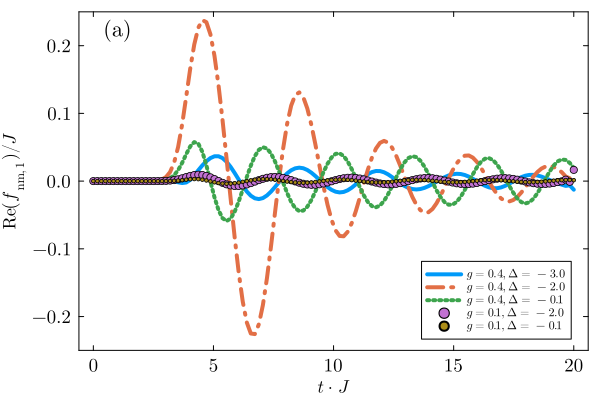

In [58]:
using Plots
using LaTeXStrings
plot_font = "Computer Modern"
default(fontfamily=plot_font,linewidth=2, framestyle=:box, label=nothing, grid=false)

plot_a = plot(times,real(f_nm_mat_gauss1[1,1,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[1])"),linewidth = 4)
plot!(times,real(f_nm_mat_gauss1[1,2,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[2])"),linewidth = 4,linestyle = :dashdot)
#plot!(times,real(f_nm_mat_gauss1[1,3,:]),label = "g = $(g_vec[1]), Delta = $(Delta_vec[3])")
plot!(times,real(f_nm_mat_gauss1[1,4,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
scatter!(times,real(f_nm_mat_gauss1[2,2,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
scatter!(times,real(f_nm_mat_gauss1[2,4,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t\\cdot J"), ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},1})/J"),legend=:bottomright,ylims= 0.25*[-1,1],legendfontsize=8,ytickfontsize=12,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(a)", :black, :right,font(14,"Computer Modern"))
annotate!(1, 0.225, ftr)
#

In [59]:
savefig("f_nm_2em_gauss1.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_gauss1.png"

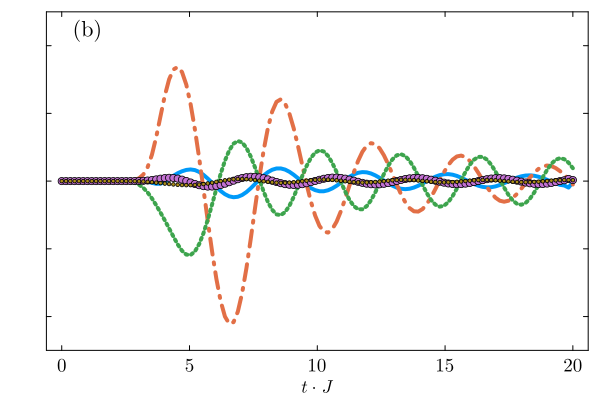

In [60]:
plot_b = plot(times,real(f_nm_mat_gauss2[1,1,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[1])"),linewidth = 4)
plot!(times,real(f_nm_mat_gauss2[1,2,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[2])"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss2[1,4,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
scatter!(times,real(f_nm_mat_gauss2[2,2,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
scatter!(times,real(f_nm_mat_gauss2[2,4,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t\\cdot J"),xtickfontsize=12,ylabels=false,ytickfontcolor=:white,legend=false,ylims= 0.25*[-1,1], xguidefontsize=12,yguidefontsize=12)
ftr = text("(b)", :black, :right,font(14,"Computer Modern"))
annotate!(1,  0.225, ftr)
#xlabel=latexstring("t/J")
#ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},2})")

In [61]:
savefig("f_nm_2em_gauss2.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_gauss2.png"

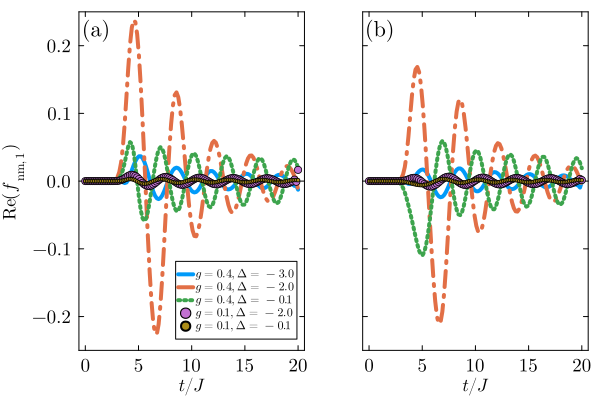

In [35]:
plot(plot_a,plot_b,layout=(2))

In [192]:
savefig("f_nm_2em_gauss_combined.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_gauss_combined.png"

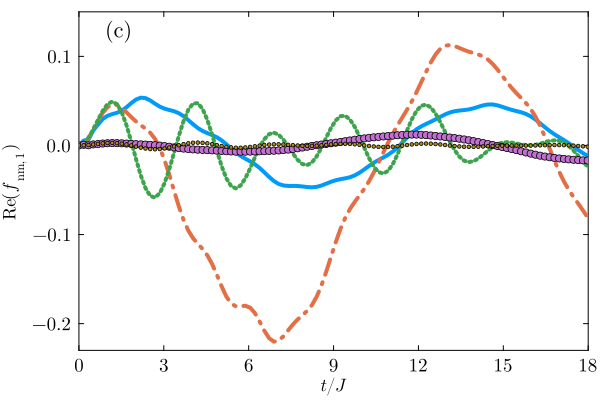

In [38]:
plot_c = plot(times,real(f_nm_mat_mono1[1,1,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[1])"),linewidth = 4)
plot!(times,real(f_nm_mat_mono1[1,2,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[2])"),linewidth = 4,linestyle = :dashdot)
#plot!(times,real(f_nm_mat_gauss1[1,3,:]),label = "g = $(g_vec[1]), Delta = $(Delta_vec[3])")
plot!(times,real(f_nm_mat_mono1[1,4,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
scatter!(times,real(f_nm_mat_mono1[2,2,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
scatter!(times,real(f_nm_mat_mono1[2,4,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t/J"), ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},1})"),xlims = [0,18],ylims = [-0.23,0.15],legend=false,legendfontsize=12,ytickfontsize=12,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(c)", :black, :right,font(14,"Computer Modern"))
annotate!(1.4, 0.13, ftr)

In [90]:
savefig("f_nm_2em_mono1.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_mono1.png"

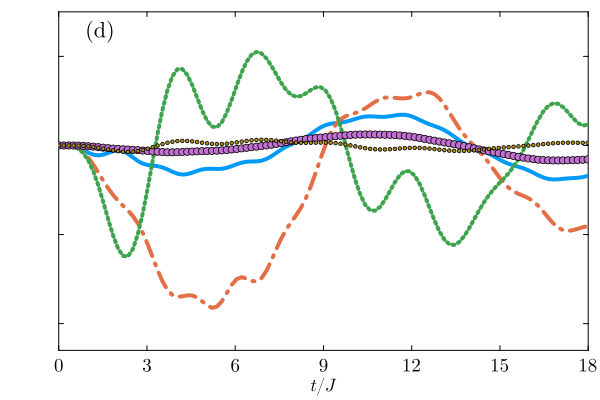

In [39]:
plot_d = plot(times,real(f_nm_mat_mono2[1,1,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[1])"),linewidth = 4)
plot!(times,real(f_nm_mat_mono2[1,2,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[2])"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_mono2[1,4,:]),label = latexstring("g = $(g_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
scatter!(times,real(f_nm_mat_mono2[2,2,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
scatter!(times,real(f_nm_mat_mono2[2,4,:]),label = latexstring("g = $(g_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t/J"),legend=false,legendfontsize=10,ytickfontcolor=:white,xlims = [0,18],ylims = [-0.23,0.15],ytickfontsize=12,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(d)", :black, :right,font(14,"Computer Modern"))
annotate!(1.4, 0.13, ftr)
#ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},2})")

In [92]:
savefig("f_nm_2em_mono2.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_mono2.png"

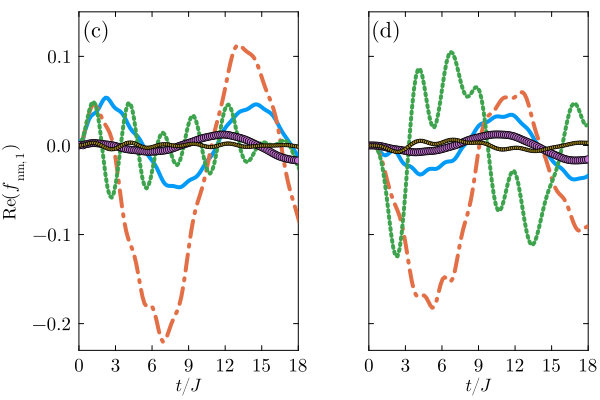

In [40]:
plot(plot_c,plot_d,layout=(2))

In [225]:
savefig("f_nm_2em_mono_combined.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_mono_combined.png"

## Comparison of increasing distance between the emitters

In [43]:
tend = 20;
times = range(0, tend, length=120)
g_vec = [0.4 0.1]
Delta_vec = [-3.0 -2.0 -1.0 -0.1]
sig = 0.5;
t0 = 4;
A = 1;
Ag = 2;
g = 0.4
d_vec=[0.1,0.2,0.4,1.0,2.0,3.0]
delta_L = 0.5
#f_const(s) = 1;
f_gauss(s) = (Ag/(sqrt(2pi*sig^2)))*exp(-(s-t0)^2/(2*sig^2))
f_mono(s) = A*exp(im*delta_L*s)
f2(s) = 0;
#Wp1, Wm1 = NE_greens_2_emit(-2.0, 0.4, 2, times);
#f_nm_gauss_1new, f_nm_gauss_2 = f_nm_2em(Wp1,Wm1,times,f_gauss,f2);
#f_nm_mono_1, f_nm_mono_2 = f_nm_2em(Wp1,Wm1,times,f_mono,f2);

Wp_mat = Array{ComplexF64}(undef,length(d_vec),length(Delta_vec),length(times))
Wm_mat = Array{ComplexF64}(undef,length(d_vec),length(Delta_vec),length(times))
f_nm_mat_gauss1 = Array{ComplexF64}(undef,length(d_vec),length(Delta_vec),length(times))
f_nm_mat_mono1 = Array{ComplexF64}(undef,length(d_vec),length(Delta_vec),length(times))
f_nm_mat_gauss2 = Array{ComplexF64}(undef,length(d_vec),length(Delta_vec),length(times))
f_nm_mat_mono2 = Array{ComplexF64}(undef,length(d_vec),length(Delta_vec),length(times))

for (i,d) in enumerate(d_vec)
    for(ii,Delta) in enumerate(Delta_vec)
        Wp_mat[i,ii,:],Wm_mat[i,ii,:] = NE_greens_2_emit(Delta,g,d, times)
        f_nm_mat_gauss1[i,ii,:], f_nm_mat_gauss2[i,ii,:] = f_nm_2em(Wp_mat[i,ii,:],Wm_mat[i,ii,:],times,f_gauss,f2)
        f_nm_mat_mono1[i,ii,:], f_nm_mat_mono2[i,ii,:] = f_nm_2em(Wp_mat[i,ii,:],Wm_mat[i,ii,:],times,f_mono,f2)
    end
end


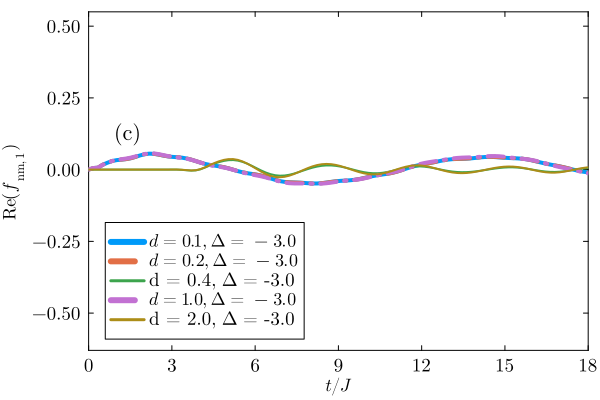

In [82]:
plot_c = plot(times,real(f_nm_mat_mono1[1,1,:]),label = latexstring("d = $(d_vec[1]), \\Delta = $(Delta_vec[1])"),linewidth = 4)
plot!(times,real(f_nm_mat_mono1[2,1,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[1])"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss1[3,1,:]),label = "d = $(d_vec[3]), \\Delta = $(Delta_vec[1])")
plot!(times,real(f_nm_mat_mono1[4,1,:]),label = latexstring("d = $(d_vec[4]), \\Delta = $(Delta_vec[1])"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss1[5,1,:]),label = "d = $(d_vec[5]), \\Delta = $(Delta_vec[1])")

#plot!(times,real(f_nm_mat_mono1[1,4,:]),label = latexstring("d = $(d_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
#scatter!(times,real(f_nm_mat_mono1[2,2,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)

#scatter!(times,real(f_nm_mat_mono1[2,4,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t/J"), ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},1})"),xlims = [0,18],ylims = [-0.63,0.55],legend=:bottomleft,legendfontsize=12,ytickfontsize=12,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(c)", :black, :right,font(14,"Computer Modern"))
annotate!(1.4, 0.13, ftr)

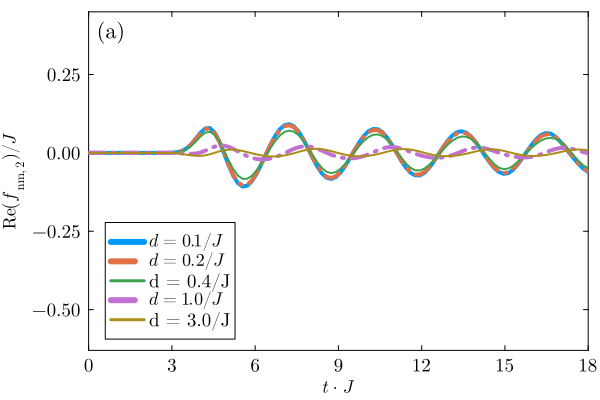

In [134]:
plot_a = plot(times,real(f_nm_mat_gauss2[1,4,:]),label = latexstring("d = $(d_vec[1])/J"),linewidth = 4)
plot!(times,real(f_nm_mat_gauss2[2,4,:]),label = latexstring("d = $(d_vec[2])/J"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss2[3,4,:]),label = "d = $(d_vec[3])/J")
plot!(times,real(f_nm_mat_gauss2[4,4,:]),label = latexstring("d = $(d_vec[4])/J"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss2[6,4,:]),label = "d = $(d_vec[6])/J")

#plot!(times,real(f_nm_mat_mono1[1,4,:]),label = latexstring("d = $(d_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
#scatter!(times,real(f_nm_mat_mono1[2,2,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
#scatter!(times,real(f_nm_mat_mono1[2,4,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t\\cdot J"), ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},2})/J"),xlims = [0,18],ylims = [-0.63,0.45],legendfontsize=12,ytickfontsize=12,legend=:bottomleft,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(a)", :black, :right,font(14,"Computer Modern"))
annotate!(0.8, 0.39, ftr)

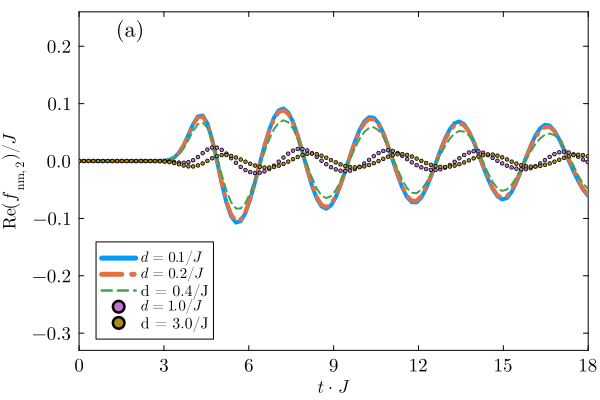

In [157]:
plot_a = plot(times,real(f_nm_mat_gauss2[1,4,:]),label = latexstring("d = $(d_vec[1])/J"),linewidth = 4)
plot!(times,real(f_nm_mat_gauss2[2,4,:]),label = latexstring("d = $(d_vec[2])/J"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss2[3,4,:]),label = "d = $(d_vec[3])/J",linestyle = :dash)
scatter!(times,real(f_nm_mat_gauss2[4,4,:]),label = latexstring("d = $(d_vec[4])/J"),markersize = 2)
scatter!(times,real(f_nm_mat_gauss2[6,4,:]),label = "d = $(d_vec[6])/J",markersize = 2)

#plot!(times,real(f_nm_mat_mono1[1,4,:]),label = latexstring("d = $(d_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
#scatter!(times,real(f_nm_mat_mono1[2,2,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
#scatter!(times,real(f_nm_mat_mono1[2,4,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t\\cdot J"), ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},2})/J"),xlims = [0,18],ylims = [-0.33,0.26],legendfontsize=10,ytickfontsize=12,legend=:bottomleft,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(a)", :black, :right,font(14,"Computer Modern"))
annotate!(1.8, 0.23, ftr)

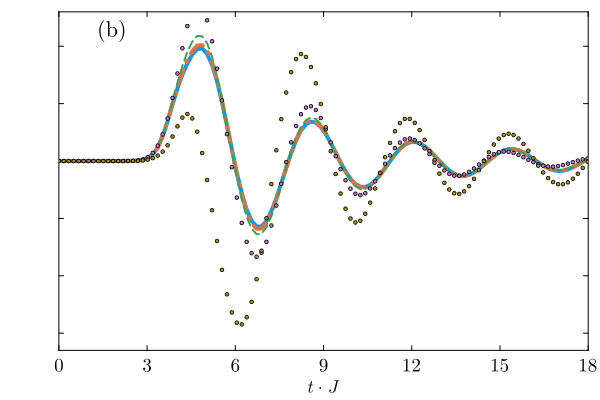

In [167]:
plot_b = plot(times,real(f_nm_mat_gauss2[1,2,:]),label = latexstring("d = $(d_vec[1])/J"),linewidth = 4)
plot!(times,real(f_nm_mat_gauss2[2,2,:]),label = latexstring("d = $(d_vec[2])/J"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss2[3,2,:]),label = "d = $(d_vec[3])/J",linestyle = :dash)
scatter!(times,real(f_nm_mat_gauss2[4,2,:]),label = latexstring("d = $(d_vec[4])/J"),markersize = 2)
scatter!(times,real(f_nm_mat_gauss2[6,2,:]),label = "d = $(d_vec[6])/J",markersize = 2)

#plot!(times,real(f_nm_mat_mono1[1,4,:]),label = latexstring("d = $(d_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
#scatter!(times,real(f_nm_mat_mono1[2,2,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
#scatter!(times,real(f_nm_mat_mono1[2,4,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t\\cdot J"),xlims = [0,18],legend=false,ylims = [-0.33,0.26],ytickfontcolor=:white,legendfontsize=10,ytickfontsize=12,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(b)", :black, :right,font(14,"Computer Modern"))
annotate!(1.8, 0.23, ftr)

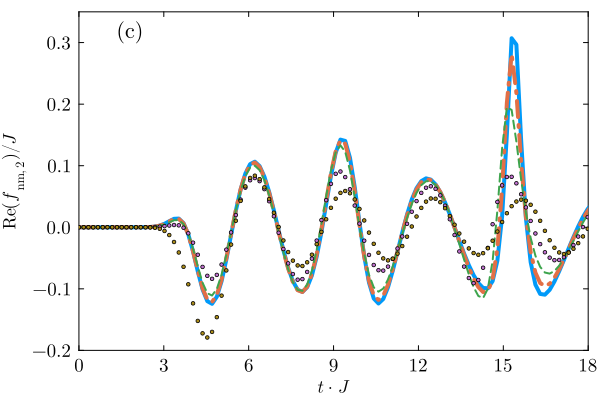

In [160]:
plot_c = plot(times,real(f_nm_mat_gauss2[1,3,:]),label = latexstring("d = $(d_vec[1])/J"),linewidth = 4)
plot!(times,real(f_nm_mat_gauss2[2,3,:]),label = latexstring("d = $(d_vec[2])/J"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss2[3,3,:]),label = "d = $(d_vec[3])/J",linestyle = :dash)
scatter!(times,real(f_nm_mat_gauss2[4,3,:]),label = latexstring("d = $(d_vec[4])/J"),markersize = 2)
scatter!(times,real(f_nm_mat_gauss2[6,3,:]),label = "d = $(d_vec[6])/J",markersize = 2)

#plot!(times,real(f_nm_mat_mono1[1,4,:]),label = latexstring("d = $(d_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
#scatter!(times,real(f_nm_mat_mono1[2,2,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
#scatter!(times,real(f_nm_mat_mono1[2,4,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t\\cdot J"), ylabel=latexstring("\\mathrm{Re}(f_{\\mathrm{nm},2})/J"),xlims = [0,18],legend=false,ylims = [-0.2,0.35],legendfontsize=12,ytickfontsize=12,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(c)", :black, :right,font(14,"Computer Modern"))
annotate!(1.8, 0.32, ftr)

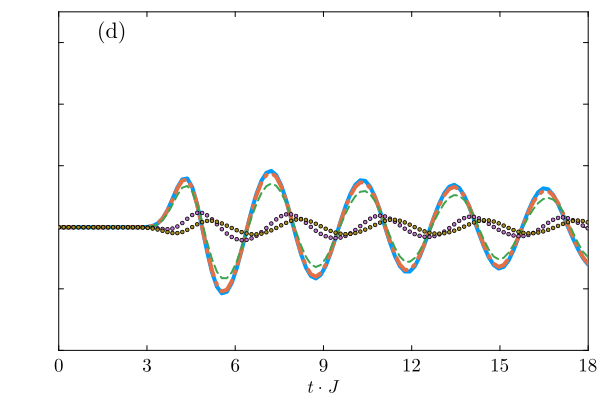

In [173]:
plot_d = plot(times,real(f_nm_mat_gauss2[1,4,:]),label = latexstring("d = $(d_vec[1])/J"),linewidth = 4)
plot!(times,real(f_nm_mat_gauss2[2,4,:]),label = latexstring("d = $(d_vec[2])/J"),linewidth = 4,linestyle = :dashdot)
plot!(times,real(f_nm_mat_gauss2[3,4,:]),label = "d = $(d_vec[3])/J",linestyle = :dash)
scatter!(times,real(f_nm_mat_gauss2[4,4,:]),label = latexstring("d = $(d_vec[4])/J"),markersize = 2)
scatter!(times,real(f_nm_mat_gauss2[6,4,:]),label = "d = $(d_vec[6])/J",markersize = 2)

#plot!(times,real(f_nm_mat_mono1[1,4,:]),label = latexstring("d = $(d_vec[1]), \\Delta = $(Delta_vec[4])"),linewidth = 4,linestyle = :dot)
#scatter!(times,real(f_nm_mat_mono1[2,2,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[2])"),markersize = 4)
#scatter!(times,real(f_nm_mat_mono1[2,4,:]),label = latexstring("d = $(d_vec[2]), \\Delta = $(Delta_vec[4])"),markersize = 2)
scatter!(xlabel=latexstring("t\\cdot J"),ytickfontcolor=:white,xlims = [0,18],legend=false,ylims = [-0.2,0.35],legendfontsize=12,ytickfontsize=12,xtickfontsize=12, xguidefontsize=12,yguidefontsize=12)
ftr = text("(d)", :black, :right,font(14,"Computer Modern"))
annotate!(1.8, 0.32, ftr)

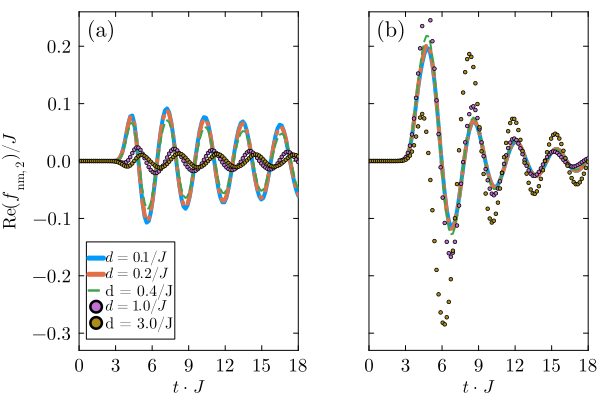

In [169]:
plot(plot_a,plot_b,layout=(2))

In [170]:
savefig("f_nm_2em_gauss_dist_comp_1.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_gauss_dist_comp_1.png"

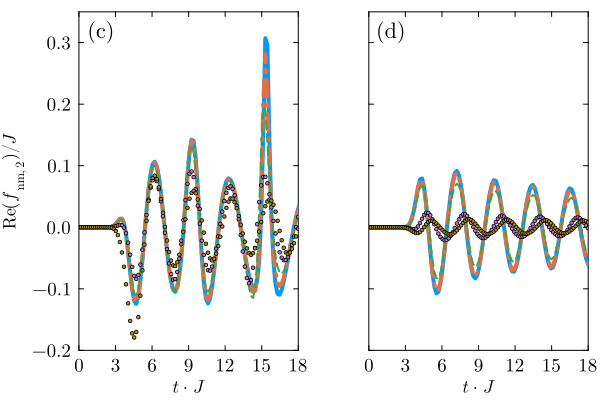

In [174]:
plot(plot_c,plot_d,layout=(2))

In [175]:
savefig("f_nm_2em_gauss_dist_comp_2.png")

"/Users/roiedann/Documents/Ongoing projects/Driven non-Markovian systems/julia_files/f_nm_2em_gauss_dist_comp_2.png"